In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error



Unnamed: 0 是由于在读取数据时，DataFrame默认将索引列也作为一个列进行了保存，因此产生了这个名为Unnamed: 0的列。通常情况下，这个列对模型的训练和预测是没有影响的，因为它只是一个索引列，并不包含任何有关预测目标的信息。

In [100]:
df = pd.read_csv(r"D:\s-casa毕业论文-工程\R5R_TEST1_london\Test2_onmypoi_data\mergeResult\housing_accessibility_3614.csv")

# Define a function to detect outliers based on the IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Use the function to detect outliers in 'Price_per_square_meter'
outliers = detect_outliers(df, 'Price_per_square_meter')
# Keep only the rows in df that are not in the outliers DataFrame
df = df[~df.index.isin(outliers.index)]



# Perform one-hot encoding on the categorical variables
df_encoded = pd.get_dummies(df, columns=['property_type', 'borough'])

# Define predictors and target variable
X = df_encoded.drop(['price', 'address', 
        'lat', 'lon', 'Price_per_square_meter', 'id'], axis=1)
y = df_encoded['Price_per_square_meter']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



'n_estimators': 100

Train RMSE: 758.1720554498072

Test RMSE: 2470.2612134708056

Train R²: 0.9807382746297026

Test R²: 0.7979608884797488

In [101]:
# 创建XGBoost回归模型
xgb_model = xgb.XGBRegressor()

# 训练模型
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [102]:
def testResult(xgb_model):
    # 预测训练集和测试集
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # 计算均方根误差（RMSE）作为性能指标
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")


    # 计算训练集和测试集的R²值
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Train R²: {train_r2}")
    print(f"Test R²: {test_r2}")
    #print(f"params: { xgb_model.get_params()}")

    # 计算训练集和测试集的MAPE值
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f"Train MAPE: {train_mape:.2f}%")
    print(f"Test MAPE: {test_mape:.2f}%")



In [103]:
testResult(xgb_model)

Train RMSE: 505.8649150808819
Test RMSE: 1727.385703014799
Train R²: 0.9691164957522815
Test R²: 0.6109632834990357
Train MAPE: 5.07%
Test MAPE: 18.01%


删异常值263行

Train RMSE: 467.7221846060159
Test RMSE: 1613.3795934985558
Train R²: 0.9794378771214889
Test R²: 0.7447291802585059

Train MAPE: 4.59%
Test MAPE: 15.82%

不删异常值

Train RMSE: 594.5792650959186
Test RMSE: 2580.873616298751
Train R²: 0.9885621864051578
Test R²: 0.7529165829591934

Train MAPE: 5.25%
Test MAPE: 16.86%

---

要建立一个XGBoost模型并减少过拟合:按照0.7、0.2、0.1的比例重新划分数据集，并训练XGBoost模型

In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv(r"D:\s-casa毕业论文-工程\R5R_TEST1_london\Test2_onmypoi_data\mergeResult\housing_accessibility_remove_outliers.csv")

# Define a function to detect outliers based on the IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Use the function to detect outliers in 'Price_per_square_meter'
outliers = detect_outliers(df, 'Price_per_square_meter')
# Keep only the rows in df that are not in the outliers DataFrame
df = df[~df.index.isin(outliers.index)]

# Perform one-hot encoding on the categorical variables
df_encoded = pd.get_dummies(df, columns=['property_type', 'borough'])

# Define predictors and target variable
X = df_encoded.drop(['price', 'address', 'lat', 'lon', 'Price_per_square_meter', 'id'], axis=1)
y = df_encoded['Price_per_square_meter']

# Split data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# 创建XGBoost回归模型并添加正则化和早停
xgb_model = xgb.XGBRegressor(reg_alpha=0.1, reg_lambda=0.1)

# 训练模型并提供验证集用于早停
eval_set = [(X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False)

# 获取最佳迭代轮数
best_iteration = xgb_model.best_iteration

# 预测训练集和测试集
y_train_pred = xgb_model.predict(X_train, ntree_limit=best_iteration)
y_test_pred = xgb_model.predict(X_test, ntree_limit=best_iteration)

# 计算均方根误差（RMSE）作为性能指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# 计算训练集和测试集的R²值
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

# 计算训练集和测试集的MAPE值
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")


c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 686.7043609789099
Test RMSE: 1902.1996051089238
Train R²: 0.9560106243928561
Test R²: 0.6443666723891286
Train MAPE: 6.87%
Test MAPE: 19.19%


c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [105]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the dataset
# df = pd.read_csv(r"D:\s-casa毕业论文-工程\R5R_TEST1_london\Test2_onmypoi_data\mergeResult\housing_accessibility_remove_outliers.csv")

# # Define a function to detect outliers based on the IQR method
# def detect_outliers(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
#     return outliers

# # Use the function to detect outliers in 'Price_per_square_meter'
# outliers = detect_outliers(df, 'Price_per_square_meter')
# # Keep only the rows in df that are not in the outliers DataFrame
# df = df[~df.index.isin(outliers.index)]

# # Perform one-hot encoding on the categorical variables
# df_encoded = pd.get_dummies(df, columns=['property_type', 'borough'])

# # Define predictors and target variable
# X = df_encoded.drop(['price', 'address', 'lat', 'lon', 'Price_per_square_meter', 'id'], axis=1)
# y = df_encoded['Price_per_square_meter']

# # Split data into train, test, and validation sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# # 创建XGBoost回归模型并添加正则化和早停
# xgb_model = xgb.XGBRegressor()

# # 定义超参数搜索空间
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'reg_alpha': [0.1, 0.01, 0.001],
#     'reg_lambda': [0.1, 0.01, 0.001]
# }

# # 使用GridSearchCV进行超参数搜索
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # 获取最佳超参数组合
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # 使用最佳超参数重新训


In [106]:
#testResult(grid_search)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}

Train RMSE: 342.73999873636814
Test RMSE: 1705.9568860130194
Train R²: 0.9890418366940535
Test R²: 0.7139602554699078
Train MAPE: 3.55%
Test MAPE: 15.89%

下面是用这个参数跑的xgb模型

In [107]:

# 创建XGBoost回归模型并添加正则化和早停
xgb_model = xgb.XGBRegressor(learning_rate=0.2, max_depth=7, min_child_weight=1, reg_alpha=0.1, reg_lambda=0.01)

# 训练模型并提供验证集用于早停
eval_set = [(X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=False)

# 获取最佳迭代轮数
best_iteration = xgb_model.best_iteration

# 预测训练集和测试集
y_train_pred = xgb_model.predict(X_train, ntree_limit=best_iteration)
y_test_pred = xgb_model.predict(X_test, ntree_limit=best_iteration)
testResult(xgb_model)


c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 478.0504415573823
Test RMSE: 1896.699715851097
Train R²: 0.9786815495686503
Test R²: 0.6464202069099751
Train MAPE: 4.80%
Test MAPE: 18.73%


c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


---

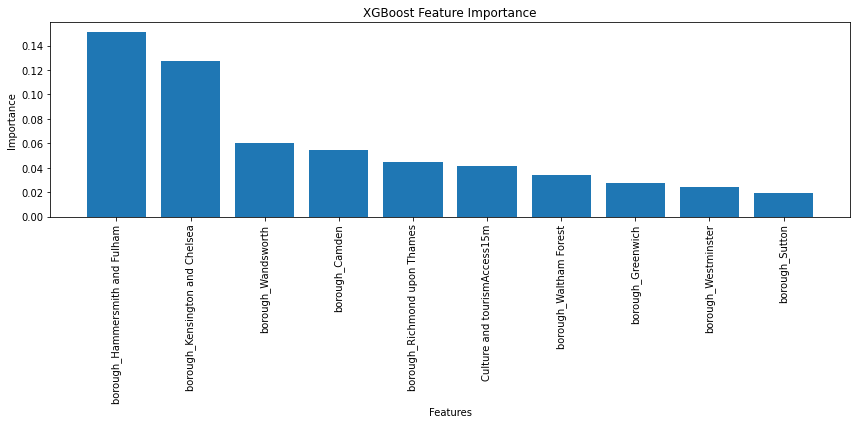

In [108]:

# 获取特征重要性数组
feature_importance = xgb_model.feature_importances_

# 获取特征名列表（假设你的X_train是一个DataFrame）
feature_names = X_train.columns

# 将特征重要性和特征名组合成一个DataFrame，便于排序和绘制
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 按照特征重要性降序排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 取前十项特征
top_10_features = importance_df.head(10)

# 绘制柱状图
plt.figure(figsize=(12, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


In [109]:
top_10_features

,Feature,Importance
54,borough_Hammersmith and Fulham,0.151422
61,borough_Kensington and Chelsea,0.127696
73,borough_Wandsworth,0.059923
47,borough_Camden,0.054694
68,borough_Richmond upon Thames,0.044608
5,Culture and tourismAccess15m,0.041435
72,borough_Waltham Forest,0.034286
52,borough_Greenwich,0.027372
74,borough_Westminster,0.024305
70,borough_Sutton,0.019069


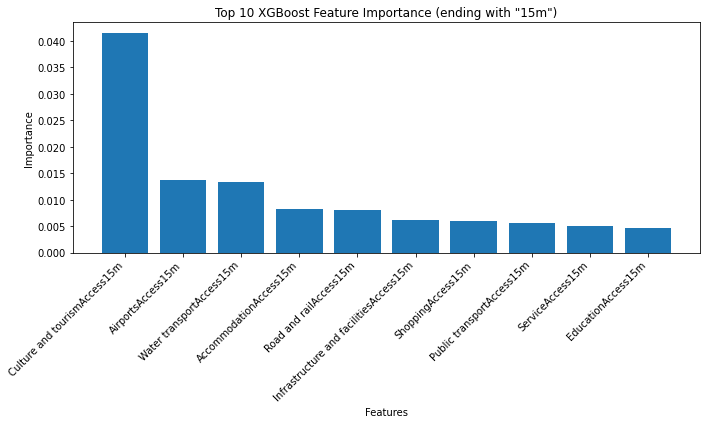

In [110]:
import matplotlib.pyplot as plt

# 获取特征重要性数组
feature_importance = xgb_model.feature_importances_

# 获取特征名列表（假设你的X_train是一个DataFrame）
feature_names = X_train.columns

# 将特征重要性和特征名组合成一个DataFrame，便于排序和绘制
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 筛选特征名以"15m"结尾的特征
selected_features = importance_df[importance_df['Feature'].str.endswith('15m')]

# 按照特征重要性降序排序
selected_features = selected_features.sort_values(by='Importance', ascending=False)

# 取前十项特征
top_10_features = selected_features.head(10)

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 XGBoost Feature Importance (ending with "15m")')
plt.tight_layout()
plt.show()


In [111]:
selected_features

,Feature,Importance
5,Culture and tourismAccess15m,0.041435
4,AirportsAccess15m,0.013643
17,Water transportAccess15m,0.013363
3,AccommodationAccess15m,0.008183
14,Road and railAccess15m,0.007976
10,Infrastructure and facilitiesAccess15m,0.006215
16,ShoppingAccess15m,0.006076
13,Public transportAccess15m,0.005619
15,ServiceAccess15m,0.005017
7,EducationAccess15m,0.004665


“Culture and tourismAccess15m”具有最高的特征重要性得分（0.111425），这表明这个特征在模型中起着非常重要的作用，对预测结果的影响最大。


需要注意的是，这并不意味着重要性较低的特征就无关紧要或者不重要。它们可能在某些特定的上下文或条件下依然会对预测结果产生影响。

同时，也要注意，XGBoost模型的特征重要性得分并不能直接等同于特征对预测目标的影响方向（正面或负面）。

网格搜索，自己调参

In [112]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'learning_rate': [0.3,0,5,1.0,],
    'n_estimators': [900,800,700,600],
    'max_depth': [2, 3, 5]
}

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best Parameters: ", grid_search.best_params_)

testResult(grid_search)


c:\Users\84398\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [ 0.6006548   0.60303598  0.60634879  0.60791643  0.58623298  0.58761739
  0.58839748  0.58986241  0.60211916  0.60211655  0.60212673  0.60217406
 -6.79302765 -6.79302765 -6.79302765 -6.79302765 -6.79302765 -6.79302765
 -6.79302765 -6.79302765 -6.79302765 -6.79302765 -6.79302765 -6.79302765
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.41832965  0.4175915   0.41963186  0.42367096  0.37887683  0.37881907
  0.378816    0.37913962  0.29904798  0.29904798  0.29904798  0.29904798]
  warnings.warn(


Best Parameters:  {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 600}
Train RMSE: 1031.732329597594
Test RMSE: 1858.3059541206144
Train R²: 0.9007015965854104
Test R²: 0.6605899358187981
Train MAPE: 10.32%
Test MAPE: 18.11%


分区域单独训练

In [113]:
df = pd.read_csv(r"D:\s-casa毕业论文-工程\R5R_TEST1_london\Test2_onmypoi_data\mergeResult\housing_accessibility_remove_outliers.csv")
# 使用布尔索引选取 borough 列值为 'Tower Hamlets' 的行

tower_hamlets_df = df[df['borough'] == 'Kensington and Chelsea']
# 删除 borough 列
tower_hamlets_df = tower_hamlets_df.drop('borough', axis=1)




In [114]:


# Perform one-hot encoding on the categorical variables
df_encoded = pd.get_dummies(tower_hamlets_df, columns=['property_type'])

# Define predictors and target variable
X = df_encoded.drop(['price', 'address', 
        'lat', 'lon', 'Price_per_square_meter', 'id'], axis=1)
y = df_encoded['Price_per_square_meter']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建XGBoost回归模型
xgb_model = xgb.XGBRegressor()

# 训练模型
xgb_model.fit(X_train, y_train)

testResult(xgb_model)


Train RMSE: 3.79355630172618
Test RMSE: 4186.057258148692
Train R²: 0.9999996435905051
Test R²: 0.6606979498871126
Train MAPE: 0.01%
Test MAPE: 16.03%


In [115]:
# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Create a DataFrame to store the true and predicted values
results_df = pd.DataFrame({'True Values': y_test.values, 'Predicted Values': y_test_pred})

# Print the DataFrame with true and predicted values
print(results_df)

     True Values  Predicted Values
0   17006.802720      15878.594727
1   16666.666670      13336.717773
2   13173.652690      19475.414062
3   42682.926830      36762.707031
4   20491.803280      19974.035156
5   24900.398410      24734.013672
6   26209.677420      20075.433594
7   15432.098770      17558.638672
8   36363.636360      36363.476562
9   17135.862910      17137.029297
10  22857.142860      22861.308594
11  21313.364060      20001.542969
12  13100.436680      13484.448242
13  16037.735850      16037.856445
14  13227.513230      14122.529297
15  17006.802720      20316.992188
16  14705.882350      14707.398438
17  20161.290320      20505.394531
18  18259.385670      19832.261719
19  21017.699120      30565.732422
20  13172.043010      22687.445312
21  38435.374150      33523.929688
22  22403.846150      25375.925781
23  27173.913040      17075.830078
24  26859.504130      26629.830078
25  18670.886080      24805.255859
26  15773.809520      16766.574219
27  24844.720500    

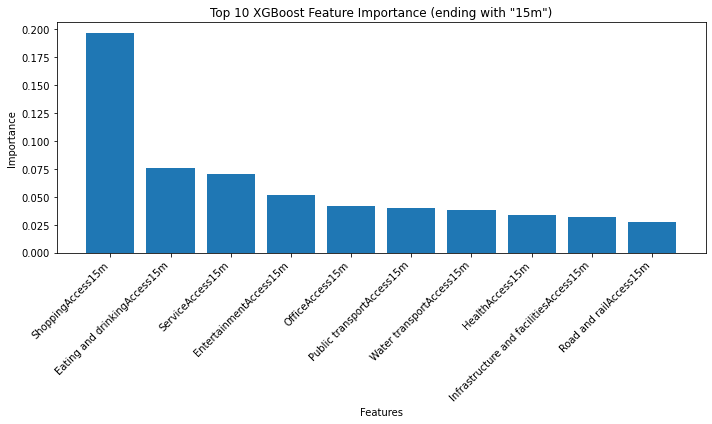

In [116]:
import matplotlib.pyplot as plt

# 获取特征重要性数组
feature_importance = xgb_model.feature_importances_

# 获取特征名列表（假设你的X_train是一个DataFrame）
feature_names = X_train.columns

# 将特征重要性和特征名组合成一个DataFrame，便于排序和绘制
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 筛选特征名以"15m"结尾的特征
selected_features = importance_df[importance_df['Feature'].str.endswith('15m')]

# 按照特征重要性降序排序
selected_features = selected_features.sort_values(by='Importance', ascending=False)

# 取前十项特征
top_10_features = selected_features.head(10)

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 XGBoost Feature Importance (ending with "15m")')
plt.tight_layout()
plt.show()


In [117]:

# Load the dataset
df = pd.read_csv(r"D:\s-casa毕业论文-工程\R5R_TEST1_london\Test2_onmypoi_data\mergeResult\housing_accessibility_remove_outliers.csv")

# Filter data for Greenwich borough
greenwich_df = df[df['borough'] == 'Greenwich']

# Drop the borough column
greenwich_df = greenwich_df.drop('borough', axis=1)

# Perform one-hot encoding on the categorical variables
df_encoded = pd.get_dummies(greenwich_df, columns=['property_type'])

# Define predictors and target variable
X = df_encoded.drop(['price', 'address', 'lat', 'lon', 'Price_per_square_meter', 'id'], axis=1)
y = df_encoded['Price_per_square_meter']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost regression model
xgb_model = xgb.XGBRegressor()

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Create a DataFrame to store the true and predicted values
results_df = pd.DataFrame({'True Values': y_test.values, 'Predicted Values': y_test_pred})

# Print the DataFrame with true and predicted values
print(results_df)


    True Values  Predicted Values
0   3571.428571       6461.863770
1   7317.073171       6982.560059
2   5942.622951       8644.288086
3   6200.000000       5934.482910
4   5840.336134       7780.516602
5   7442.748092       5823.399902
6   6547.619048       5681.216309
7   7375.000000       7607.452148
8   6493.506494       5739.411621
9   9705.882353       8567.356445
10  5722.891566       5723.051758
11  7714.285714       7713.885742
12  6315.789474       5786.059082
13  4661.016949       5609.778320
14  6567.164179       7859.361816
15  5000.000000       4999.951660
16  7913.669065       9288.755859
17  5597.014925       6642.564941
18  7377.049180       7377.056152
19  7442.748092       5823.399902
20  7777.777778       6187.074707
21  9400.000000       9045.877930
22  8802.816901       7578.818359
23  5000.000000       4999.951660
24  6500.000000       8111.124023
25  7425.742574       7661.066406
26  8333.333333      11093.773438
27  7500.000000       6612.611328


In [118]:
testResult(xgb_model)

Train RMSE: 0.1492495537144541
Test RMSE: 1316.9437974939137
Train R²: 0.9999999930038836
Test R²: 0.09793775556574114
Train MAPE: 0.00%
Test MAPE: 15.97%


In [119]:
from sklearn.metrics import r2_score

# Calculate R-squared (R²) value
r2 = r2_score(y_test, y_test_pred)

print(f"R-squared (R²) value: {r2}")


R-squared (R²) value: 0.09793775556574114


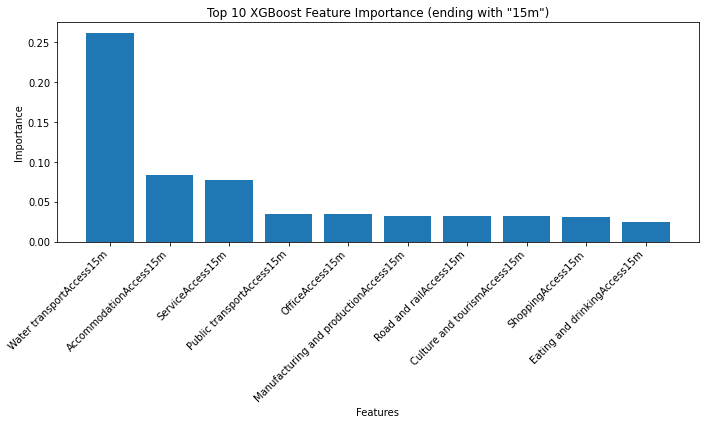

In [120]:
import matplotlib.pyplot as plt

# 获取特征重要性数组
feature_importance = xgb_model.feature_importances_

# 获取特征名列表（假设你的X_train是一个DataFrame）
feature_names = X_train.columns

# 将特征重要性和特征名组合成一个DataFrame，便于排序和绘制
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 筛选特征名以"15m"结尾的特征
selected_features = importance_df[importance_df['Feature'].str.endswith('15m')]

# 按照特征重要性降序排序
selected_features = selected_features.sort_values(by='Importance', ascending=False)

# 取前十项特征
top_10_features = selected_features.head(10)

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 XGBoost Feature Importance (ending with "15m")')
plt.tight_layout()
plt.show()
